In [1]:
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets

from torch.utils import data
from PIL import Image
from torch.backends import cudnn
from torch import optim
from torch.autograd import Variable
from torch.utils import data
from torchvision import transforms
from torchsummary import summary
from IPython.display import clear_output
from tensorboardX import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
print("Pytorch Version", torch.__version__)

Pytorch Version 1.4.0


In [3]:
random.seed(999)
torch.manual_seed(999)

In [4]:
class ImageFolder(data.Dataset):
    def __init__(self, root, transform=None):
        # os.listdir Function gives all lists of directory
        self.image_paths = list(map(lambda x: os.path.join(root, x), os.listdir(root)))
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')

        # Transform
        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self):
        return len(self.image_paths)

def Denorm(img):
    out = (img + 1) / 2
    return img.clamp(0, 1)

In [5]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class G(nn.Module):
    def __init__(self, z_dim=100, channel=3):
        super(G, self).__init__()
        self.z_dim = z_dim
        self.Generator = nn.Sequential(
            Reshape((-1, z_dim, 1, 1)),
            # [-1, 100, 1, 1] -> [-1, 1024, 4, 4]
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),

            # [-1, 512, 8, 8]
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # [-1, 256, 16, 16]
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # [-1, 128, 32, 32]
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # [-1, 64, 3, 3]
            nn.ConvTranspose2d(64, channel, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        # [-1, 100] -> [-1, 100, 1, 1]
        return self.Generator(z)


class D(nn.Module):
    def __init__(self, channel=3):
        super(D, self).__init__()
        self.Discriminator = nn.Sequential(
            # [-1, 3, 64, 64] -> [-1, 128, 32, 32]
            nn.Conv2d(channel, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.05, inplace=True),

            # [-1, 256, 16, 16]
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # [-1, 512, 8, 8]
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # [-1, 1024, 4, 4]
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # [-1, 1, 1, 1]
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Sigmoid()
        )
    def forward(self, x):
        # [-1, 1, 1, 1] -> [-1, 1]
        return self.Discriminator(x)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == "cuda":
    torch.cuda.init()
    cudnn.benchmark = True
    print(torch.cuda.get_device_name())

writer = SummaryWriter("./logs")

GeForce GTX 1060 6GB


In [7]:
## Models & Optimizers define
Gen = G(100, 1).to(device)
Dis = D(1).to(device)
G_opti = optim.Adam(Gen.parameters(), 2e-4, [0.5, 0.999])
D_opti = optim.Adam(Dis.parameters(), 2e-4, [0.5, 0.999])

# Print Model summary
summary(Gen, (100, ), batch_size=128, device=device)
summary(Dis, (1, 64, 64), batch_size=128, device=device)

writer.add_graph(Gen, (torch.zeros(128, 100).to(device), ))
writer.add_graph(Dis, (torch.zeros(128, 1, 64, 64).to(device), ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Reshape-1           [128, 100, 1, 1]               0
   ConvTranspose2d-2           [128, 512, 4, 4]         819,200
   ConvTranspose2d-3           [128, 256, 8, 8]       2,097,152
       BatchNorm2d-4           [128, 256, 8, 8]             512
              ReLU-5           [128, 256, 8, 8]               0
   ConvTranspose2d-6         [128, 128, 16, 16]         524,288
       BatchNorm2d-7         [128, 128, 16, 16]             256
              ReLU-8         [128, 128, 16, 16]               0
   ConvTranspose2d-9          [128, 64, 32, 32]         131,072
      BatchNorm2d-10          [128, 64, 32, 32]             128
             ReLU-11          [128, 64, 32, 32]               0
  ConvTranspose2d-12           [128, 1, 64, 64]           1,024
             Tanh-13           [128, 1, 64, 64]               0
                G-14           [128, 1,

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
Gen.apply(weights_init)

G(
  (Generator): Sequential(
    (0): Reshape()
    (1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)

In [10]:
Dis.apply(weights_init)

D(
  (Discriminator): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.05, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Flatten()
    (13): Sigmoid()
  )
)

In [11]:
# ngpu = torch.cuda.device_count()

# if (device == 'cuda') and (ngpu > 1):
#    Dis = nn.DataParallel(Dis, list(range(ngpu)))
#    Gen = nn.DataParallel(Gen, list(range(ngpu)))    

In [25]:
# Define Data Transfomr Composition
transform_pipe = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, ), (0.5, ))]
)

# Get the dataset LSUN or CelebA
# Default dataset is CelebA
# dataset = ImageFolder("C:\\Users\\H\\Desktop\\GAN\\train\\img_align_celeba", transform)
dataset = dsets.MNIST('./MNIST', 
            train=True, 
            transform=transform_pipe,
            target_transform=None,
            download=True
)

data_loader = data.DataLoader(dataset=dataset,
                            batch_size=128,
                            shuffle=True,
                            num_workers=0,                                                                                                                                                         
                            pin_memory=True,
                            drop_last=True
)

Test real batch size: torch.Size([128, 1, 64, 64])


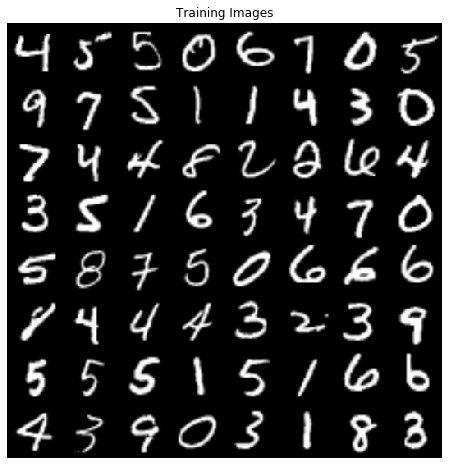

In [27]:
real_batch = next(iter(data_loader))
# print("Test real batch size:", real_batch.size())
print("Test real batch size:", real_batch[0].size())
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")

# img = torchvision.utils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu()
img = torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu()
plt.imshow(np.transpose(img, (1,2,0)))

In [20]:
from visdom import Visdom

viz = Visdom()
#viz.close(env='main')

image_windows = viz.images(torch.randn(16, 3, 64, 64), 
                 opts=dict(title = "Generated Imgs",
                 caption = "Generated Image-{}-{}".format(0, 0)))

Setting up a new session...


In [21]:
criterion = nn.BCELoss()

real = 1
fake = 0

In [29]:
import time

if not os.path.exists('./models'):
    os.makedirs('./models')
if not os.path.exists('./results'):
    os.makedirs('./results')


"""Train generator and discriminator."""
total_epoch = 10
# Define fixed noise for testing
fixed_noise = torch.randn(16, 100).to(device)
total_step = len(data_loader)

# Create label
batch_size = 128
real_label = torch.ones(batch_size, 1).to(device)
fake_label = torch.zeros(batch_size, 1).to(device)
                         
# Loss list
G_losses = []
D_losses = []

# cudnn.benchmark = True
step = 0

for epoch in range(total_epoch):
    torch.cuda.synchronize()
    epoch_time = time.time()
    
    for batch_num, images in enumerate(data_loader):
        torch.cuda.synchronize()
        s_time = time.time()
        step += 1

        images = images[0].to(device)
        # ===================== Train D ===================== #
        Dis.zero_grad()
        noise = torch.randn(batch_size, 100).to(device)

        # Fake -> Fake & Real -> Real
        fake_images = Gen(noise)
        real_dis_result = Dis(images)
        fake_dis_result = Dis(fake_images)

        D_real_loss = criterion(real_dis_result, real_label)
        D_fake_loss = criterion(fake_dis_result, fake_label)
        D_x = real_dis_result.mean().item()
        D_G_z1 = fake_dis_result.mean().item()
                         
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_opti.step()
        # ===================== Train G =====================#
        Gen.zero_grad()
        noise = torch.randn(batch_size, 100).to(device)

        # Fake -> Real
        fake_images = Gen(noise)
        fake_dis_result = Dis(fake_images)

        G_loss = criterion(fake_dis_result, real_label)
        G_loss.backward()
        G_opti.step()
        D_G_z2 = fake_dis_result.mean().item()
          
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        writer.add_scalars("Losses", {"D Loss": D_loss.cpu().data.numpy(), "G Loss": G_loss.cpu().data.numpy()}, step)
        
        torch.cuda.synchronize()
        
        clear_output(wait=True)
        template = "Epoch [{:2d}/{:2d}]    Step [{:4d}/{:4d}]    Losses [D>>{:.5f} || G>>{:.5f}]    D(x): {:.5f}    D(G(z)): {:.5f}/{:.5f}"
        print(template.format(epoch+1, total_epoch, batch_num+1, total_step, D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
        print("Epoch [{:2d}/{:2d}]    Step [{:4d}/{:4d}]    Time taken {:.4f}s".format(epoch+1, total_epoch, batch_num+1, total_step, time.time()-s_time))
        
        # print the log info
        if (batch_num + 1) % 10 == 0:
            with torch.no_grad():
                fake_images = Gen(fixed_noise)
                image_windows = viz.images(Denorm(fake_images.data), 
                     opts=dict(title = "Generated Imgs",
                     caption = "Generated Image-{}-{}".format(epoch+1, batch_num+1)),
                     win=image_windows
                )
                
                if (batch_num + 1) % 100 == 0:
                    torchvision.utils.save_image(Denorm(fake_images.data),
                                                  os.path.join('./results',
                                                              'Generated_IMGs-{:2d}-{:d}.png'.format(epoch+1, batch_num+1)))
        
    if (epoch+1) % 2 == 0:
        for name, param in Gen.named_parameters():
            writer.add_histogram(name, param.clone().cpu().data.numpy(), global_step=(epoch+1))
        
        for name, param in Dis.named_parameters():
            writer.add_histogram(name, param.clone().cpu().data.numpy(), global_step=(epoch+1))    
    
    # save the model parameters for each epoch
    g_path = os.path.join('./models', 'generator-%d.pkl' % (epoch + 1))
    torch.save(Gen.state_dict(), g_path)
    
    print("Epoch [{:2d}/{:2d}]    Time taken {:.4f}s".format(epoch+1, total_epoch, time.time()-epoch_time))

Epoch [11/10]    Step [ 468/ 468]    Losses [D>>0.06249 || G>>5.86178]    D(x): 0.99588    D(G(z)): 0.05462/0.00504
Epoch [11/10]    Step [ 468/ 468]    Time taken 0.2140s
Epoch [11/10]    Time taken 110.0080s


In [ ]:
torch.cuda.empty_cache()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()